In [6]:
import pandas as pd
from pathlib import Path
from datetime import datetime

import nltk, re, string, itertools
from nltk.corpus import stopwords
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx

nltk.download("punkt")
nltk.download("stopwords")

data_dir   = Path("data")
csv_file   = data_dir / "/Users/xinyuanxu/Desktop/data viz/hw/hw2/arxiv_subset.csv"   
json_file  = data_dir / "/Users/xinyuanxu/Desktop/data viz/hw/hw2/arxiv_subset.json"       

df = pd.read_csv(csv_file, dtype=str)
df["update_date"] = pd.to_datetime(df["update_date"])
df["year"] = df["update_date"].dt.year


[nltk_data] Downloading package punkt to /Users/xinyuanxu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xinyuanxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Text Analysis and Visualization

a) Term Frequency Analysis

In [7]:
stop_words = set(stopwords.words("english"))
punct_tbl  = str.maketrans("", "", string.punctuation + string.digits)

def clean_tokenize(text):
    tokens = nltk.word_tokenize(text.lower().translate(punct_tbl))
    return [t for t in tokens if t not in stop_words and len(t) > 2]

df["tokens"] = df["abstract"].fillna("").map(clean_tokenize)


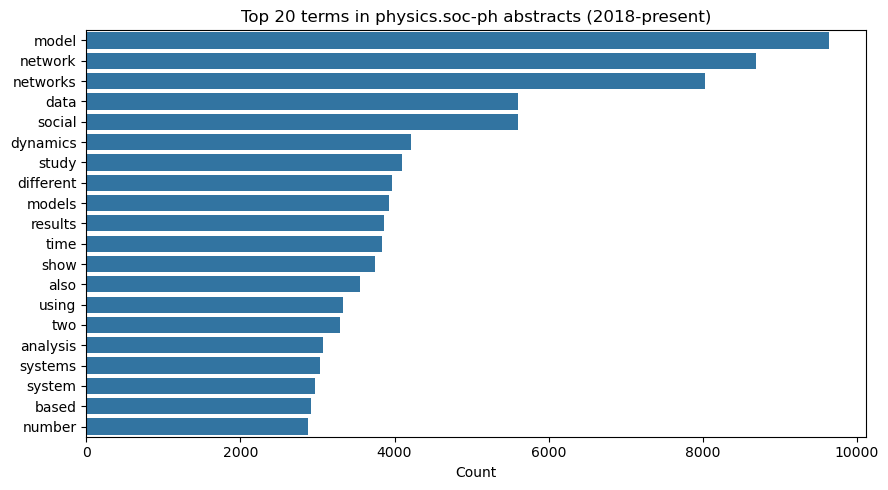

/var/folders/46/fdrjqjdn3jq9yg03908v7r_80000gn/T/ipykernel_20836/966462941.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nlargest(10, "n"))


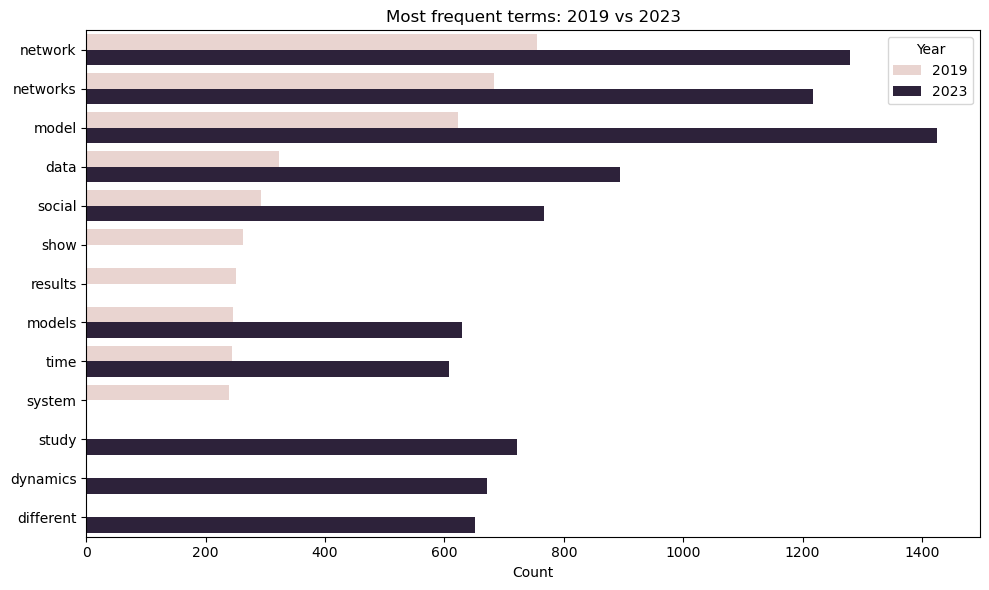

In [8]:
all_tokens   = itertools.chain.from_iterable(df["tokens"])
top20        = Counter(all_tokens).most_common(20)
terms, freqs = zip(*top20)

plt.figure(figsize=(9,5))
sns.barplot(x=list(freqs), y=list(terms), orient="h")
plt.title("Top 20 terms in physics.soc-ph abstracts (2018-present)")
plt.xlabel("Count"); plt.ylabel("")
plt.tight_layout(); plt.show()

subset = df[df["year"].isin([2019, 2023])]
year_counts = (
    subset.explode("tokens")
          .groupby(["year", "tokens"]).size()
          .reset_index(name="n")
)
top10_each = (
    year_counts.groupby("year")
               .apply(lambda g: g.nlargest(10, "n"))
               .reset_index(drop=True)
)

plt.figure(figsize=(10,6))
sns.barplot(data=top10_each,
            x="n", y="tokens",
            hue="year", orient="h")
plt.title("Most frequent terms: 2019 vs 2023")
plt.xlabel("Count"); plt.ylabel("")
plt.legend(title="Year")
plt.tight_layout(); plt.show()


b) Word Cloud

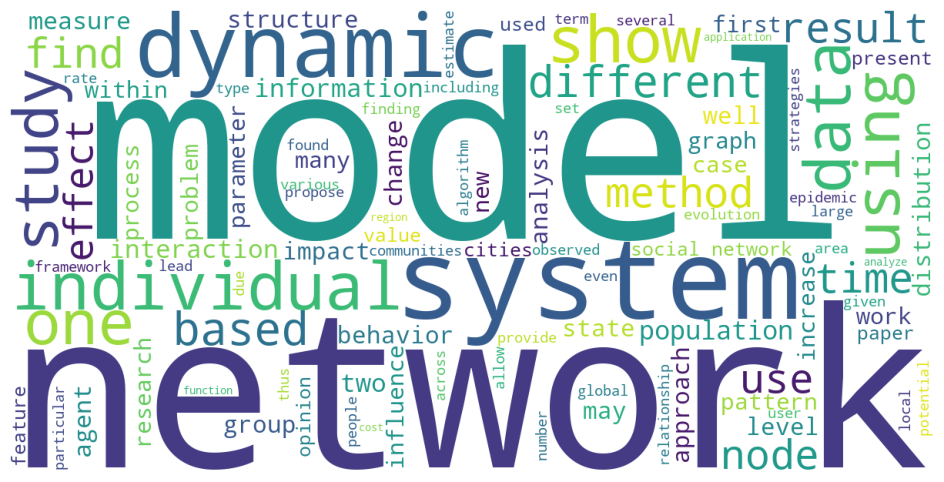

In [9]:
wc_text = " ".join(itertools.chain.from_iterable(df["tokens"]))
wc = WordCloud(width=1200, height=600,
               max_words=100,
               background_color="white",
               colormap="viridis").generate(wc_text)
plt.figure(figsize=(12,6)); plt.imshow(wc); plt.axis("off"); plt.show()


# 2. Author Collaboration Network

a) Network Construction

In [10]:
mask = df["categories"].str.contains("physics.soc-ph") & df["categories"].str.contains("cs.SI")
df_net = df[mask].copy()

df_net["author_list"] = df_net["authors"].str.split(",\s*")

author_counts = (
    df_net.explode("author_list")
          .groupby("author_list").size()
          .rename("paper_n")
)

prolific   = author_counts[author_counts >= 4].index
df_net["author_list"] = df_net["author_list"].apply(
    lambda lst: [a for a in lst if a in prolific])

edges = Counter()
for authors in df_net["author_list"]:
    for a, b in itertools.combinations(sorted(set(authors)), 2):
        edges[(a, b)] += 1

G = nx.Graph()
G.add_nodes_from(prolific)
for (a, b), w in edges.items():
    G.add_edge(a, b, weight=w)

nx.set_node_attributes(
    G, author_counts.to_dict(),
    name="paper_n")


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/var/folders/46/fdrjqjdn3jq9yg03908v7r_80000gn/T/ipykernel_20836/2023741194.py:6: SyntaxWarning: invalid escape sequence '\s'
  df_net["author_list"] = df_net["authors"].str.split(",\s*")


In [15]:
import pandas as pd
import itertools
from pathlib import Path

file = Path("data") / "/Users/xinyuanxu/Desktop/data viz/hw/hw2/arxiv_subset.csv"         
df   = pd.read_csv(file, dtype=str)

mask = (df["categories"].str.contains("physics.soc-ph")) & \
       (df["categories"].str.contains("cs.SI"))
dual_df = df[mask].copy()

print(f"{len(dual_df):,} papers with both physics.soc-ph AND cs.SI tags")


2,391 papers with both physics.soc-ph AND cs.SI tags


In [17]:
dual_df["authors_list"] = dual_df["authors"].str.split(r",\s*")

author_counts = (
    dual_df.explode("authors_list")
           .groupby("authors_list").size()
           .rename("paper_n")
)

prolific = author_counts[author_counts >= 4]
dual_df["authors_list"] = dual_df["authors_list"].apply(
    lambda lst: [a for a in lst if a in prolific.index]
)


b) Network Visualization

In [18]:
from collections import Counter
edge_counter = Counter()

for authors in dual_df["authors_list"]:
    uniq = sorted(set(authors))
    for a, b in itertools.combinations(uniq, 2):
        edge_counter[(a, b)] += 1

In [19]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(prolific.index)     
# edges
for (a, b), w in edge_counter.items():
    G.add_edge(a, b, weight=w)

nx.set_node_attributes(G, prolific.to_dict(), name="paper_n")

btw = nx.betweenness_centrality(G, weight="weight")
nx.set_node_attributes(G, btw, name="btw")


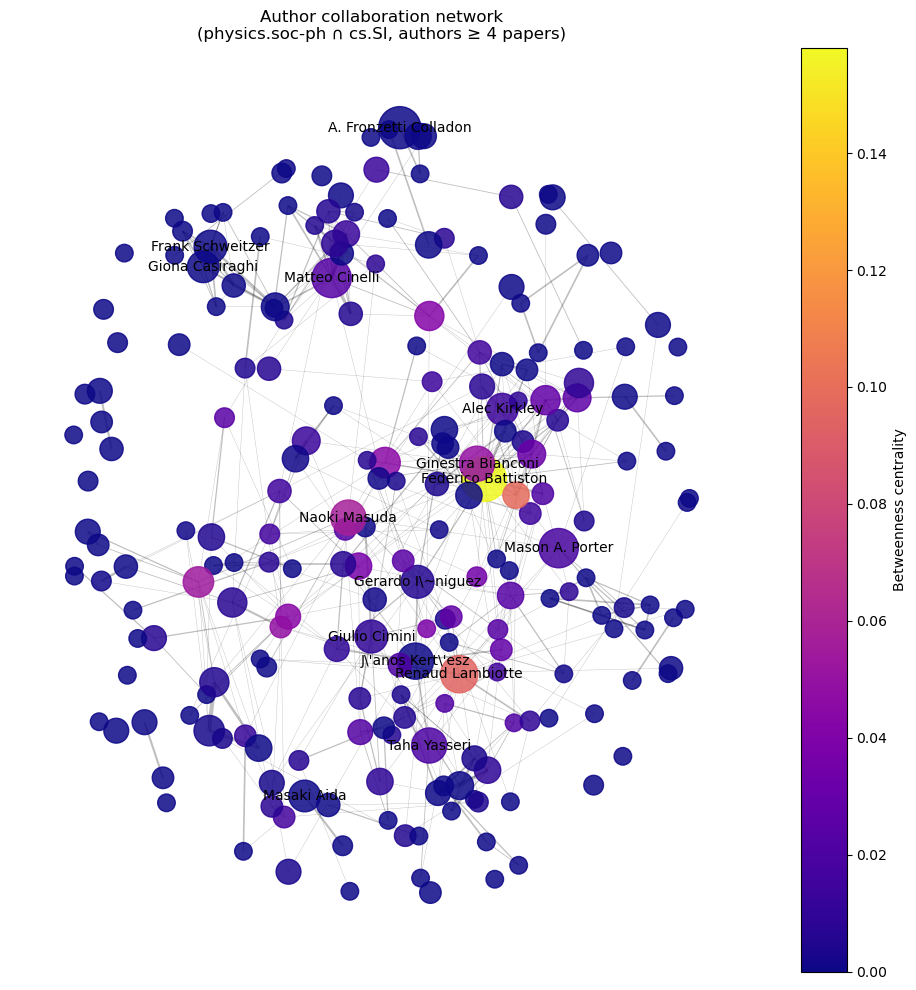

In [21]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, k=0.45, seed=42)

sizes  = [G.nodes[n]["paper_n"] * 40 for n in G.nodes]   # scale factor 40 → tweak
colors = [G.nodes[n]["btw"]        for n in G.nodes]

fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(
    G, pos, ax=ax,
    width=[d["weight"]*0.3 for *_, d in G.edges(data=True)],
    alpha=0.25)

nodes = nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_size=sizes,
    node_color=colors,
    cmap="plasma", alpha=0.85)

# label the 15 most prolific authors
top15 = prolific.sort_values(ascending=False).head(15).index
nx.draw_networkx_labels(
    G, pos,
    labels={n: n for n in top15},
    font_size=10,
    ax=ax)

sm = plt.cm.ScalarMappable(cmap="plasma",
                           norm=plt.Normalize(vmin=min(colors), vmax=max(colors)))
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Betweenness centrality")

ax.set_title("Author collaboration network\n(physics.soc-ph ∩ cs.SI, authors ≥ 4 papers)")
ax.axis("off")
plt.show()
